In [122]:
#importing libraries 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error
from matplotlib.ticker import FixedLocator
from statsmodels.tsa.stattools import adfuller
import itertools
import warnings
warnings.filterwarnings('ignore')

In [434]:
# Read the CSV files into pandas DataFrames
df1 = pd.read_csv('F:/Works/Collaborative Application Development/Day Data/D19_updated_days.csv')  # Replace with the actual file path
df2 = pd.read_csv('F:/Works/Collaborative Application Development/Day Data/D21_updated_days.csv')  # Replace with the actual file path

In [435]:
# Drop the 'Date' column from both DataFrames
df1 = df1.drop('Date', axis=1)
df2 = df2.drop('Date', axis=1)

In [436]:
# Extract 'Total Registered' column
total_registered_df1 = df1['Total Registered']
total_registered_df1 = total_registered_df1[-28:]

# Extract 'Total Registered' column
total_registered_df2 = df2['Total Registered']
total_registered_df2 = total_registered_df2[-28:]

In [437]:
# Reset index for both DataFrames
total_registered_df1.reset_index(drop=True, inplace=True)
total_registered_df2.reset_index(drop=True, inplace=True)

In [438]:
# Concatenate the DataFrames along the columns axis
df = pd.concat([total_registered_df1, total_registered_df2], axis=1)
print(df)

    Total Registered  Total Registered
0                 16                15
1                 24                11
2                  4                 5
3                 36                 1
4                  1                 1
5                  1                32
6                 18                11
7                 17                17
8                 17                14
9                 16                 9
10                 1                 1
11                 1                 1
12                 1                11
13                12                35
14                 9                12
15                50                29
16                12                17
17                50                 1
18                 1                 1
19                 1                68
20                18                23
21                80                25
22                89                15
23                22                 1
24                45     

In [439]:
# Calculate the mean along the columns axis to combine the values into a single column
df['Total Registered Data'] = df.mean(axis=1).round().astype(int)  # You can replace 'mean' with 'median', 'sum', or any other aggregation function

# Drop the original columns from the concatenated DataFrame
df = df.drop(['Total Registered'], axis=1)

In [440]:
df.reset_index(drop=True, inplace=True)

# Add a new column named "Day" starting from 1
df['Day'] = 'Day ' + (df.index + 1).astype(str)
print(df)

# Save the DataFrame to a CSV file
#df.to_csv('F:/Works/Collaborative Application Development/Merged Dataset (Last 10 Weeks)/Property_Managers.csv', index=False)

    Total Registered Data     Day
0                      16   Day 1
1                      18   Day 2
2                       4   Day 3
3                      18   Day 4
4                       1   Day 5
5                      16   Day 6
6                      14   Day 7
7                      17   Day 8
8                      16   Day 9
9                      12  Day 10
10                      1  Day 11
11                      1  Day 12
12                      6  Day 13
13                     24  Day 14
14                     10  Day 15
15                     40  Day 16
16                     14  Day 17
17                     26  Day 18
18                      1  Day 19
19                     34  Day 20
20                     20  Day 21
21                     52  Day 22
22                     52  Day 23
23                     12  Day 24
24                     23  Day 25
25                      1  Day 26
26                      1  Day 27
27                     23  Day 28


In [441]:
# Ensure 'Week' is treated as a categorical variable
df['Day'] = df['Day'].astype('category')

# Extract 'Total Registered' column
total_registered = df['Total Registered Data']

In [408]:
#For MSE21

# Load your DataFrame from the CSV file
df = pd.read_csv('F:/Works/Collaborative Application Development/Day Data/MSE21_updated_days.csv')

# Drop unnecessary columns
df = df.drop(['Date', 'Day'], axis=1)

# Extract the last 70 rows from the DataFrame
total_registered = df['Total Registered'].tail(28)

# Create a new DataFrame for the last 70 rows with a new 'Day' column
day_column = ['Day ' + str(i) for i in range(1, len(total_registered) + 1)]
day_df = pd.DataFrame({'Total Registered': total_registered.values, 'Day': day_column})

# Save the DataFrame to a CSV file
#day_df.to_csv('F:/Works/Collaborative Application Development/Merged Dataset (Last 10 Weeks)/Education_Property_Managers.csv', index=False)

# Ensure 'Day' is treated as a categorical variable
day_df['Day'] = day_df['Day'].astype('category')
# Extract 'Total Registered' column
total_registered = day_df['Total Registered']

In [444]:
# Define optimal parameters
alpha_optimal = 0.1
beta_optimal = 0.7
gamma_optimal = 0.3
seasonal_period_optimal = 3

In [445]:
# Initialize TimeSeriesSplit for cross-validation
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

In [446]:
# Initialize lists to store RMSE values for each fold
rmse_scores = []

# Perform k-fold cross-validation
for train_index, test_index in tscv.split(total_registered):
    train_len = int(len(train_index) * 0.8)  # 80% train, 20% test
    train, test = total_registered[train_index[:train_len]], total_registered[train_index[train_len:]]
    
    # Fit ExponentialSmoothing model
    model = ExponentialSmoothing(train, seasonal_periods=seasonal_period_optimal, trend='add', seasonal='add')
    model_fit = model.fit(smoothing_level=alpha_optimal, smoothing_slope=beta_optimal, smoothing_seasonal=gamma_optimal)
    
    # Make predictions
    pred = model_fit.forecast(len(test))
    
    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(test, pred))
    rmse_scores.append(rmse)

# Calculate the average RMSE across all folds
average_rmse = np.mean(rmse_scores)
print("Average RMSE:", average_rmse)

Average RMSE: 13.84816696859048


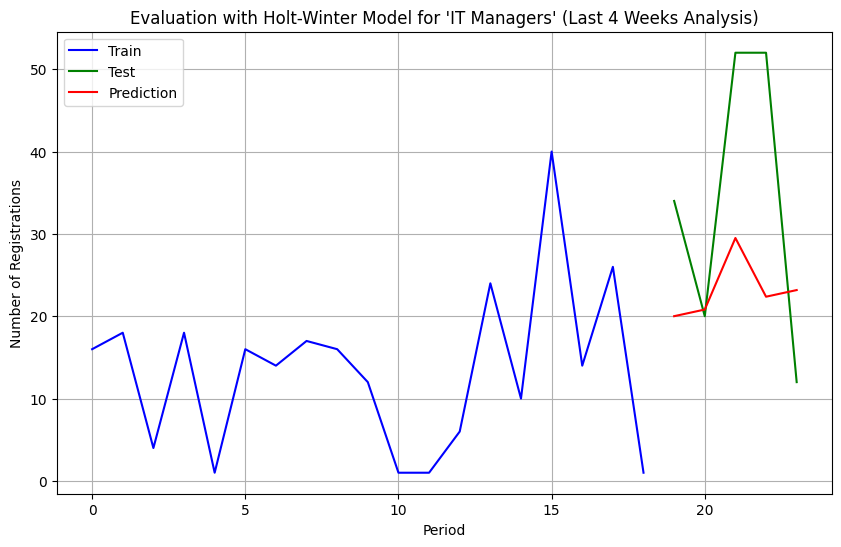

In [447]:
# Plot train, test, and prediction
plt.figure(figsize=(10, 6))
plt.plot(total_registered.index[:len(train)], train, label='Train', color='blue')
plt.plot(total_registered.index[len(train):len(train) + len(test)], test, label='Test', color='green')
plt.plot(total_registered.index[len(train):len(train) + len(pred)], pred, label='Prediction', color='red')

# Add labels and title
plt.xlabel('Period')
plt.ylabel('Number of Registrations')
plt.title("Evaluation with Holt-Winter Model for 'IT Managers' (Last 4 Weeks Analysis)")
plt.legend()
plt.grid(True)

# Save the figure
plt.savefig('F:/Works/Collaborative Application Development/Python/Images/Holt-Winter_k-Fold/Merged/Last 4 Weeks/Training/IT_Managers_Holt-Winter_5-fold_80%.png')

In [448]:
# Initialize the Holt-Winters model with optimal parameters
alpha = 0.1
beta = 0.7
gamma = 0.3
seasonal_periods = 3
final_model = ExponentialSmoothing(total_registered, seasonal_periods=seasonal_periods, trend='add', seasonal='add')

# Fit the model to the entire dataset
final_model_fit = final_model.fit(smoothing_level=alpha, smoothing_slope=beta, smoothing_seasonal=gamma)

# Forecast the next 42 days
forecast = final_model_fit.forecast(steps=42)

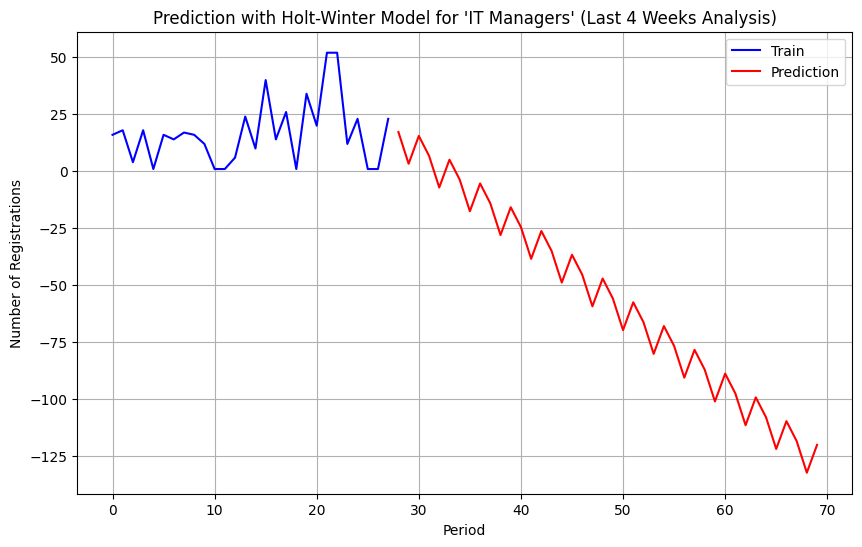

In [449]:
#Plotting the prediction graph
total_registered.plot(legend = True, label = 'Train', color='blue', figsize = (10, 6))
forecast.plot(legend = True, label = 'Prediction', color='red')

# Add labels and title
plt.xlabel('Period')
plt.ylabel('Number of Registrations')
plt.title("Prediction with Holt-Winter Model for 'IT Managers' (Last 4 Weeks Analysis)")
plt.grid(True)

# Save the figure
plt.savefig('F:/Works/Collaborative Application Development/Python/Images/Holt-Winter_k-Fold/Merged/Last 4 Weeks/Prediction/IT_Managers_Holt-Winter_5-fold_80%.png')

In [ ]:
#..............................................Finding optimal Hyperparameters..................................................#

In [443]:
# Define parameter ranges
alphas = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
betas = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
gammas = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
seasonal_periods = [2,3]  # Example seasonal periods for monthly, bi-monthly, and weekly data

# Generate all possible combinations of parameters
param_grid = product(alphas, betas, gammas, seasonal_periods)

# Initialize TimeSeriesSplit for cross-validation
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

# Perform cross-validated grid search
best_rmse = float('inf')
best_params = None

for alpha, beta, gamma, seasonal_period in param_grid:
    rmse_scores = []
    for train_index, test_index in tscv.split(total_registered):
        train_len = int(len(train_index) * 0.8)
        train, test = total_registered[train_index[:train_len]], total_registered[train_index[train_len:]]
        model = ExponentialSmoothing(train, seasonal_periods=seasonal_period, trend='add', seasonal='add')
        model_fit = model.fit(smoothing_level=alpha, smoothing_slope=beta, smoothing_seasonal=gamma)
        preds = model_fit.forecast(len(test))
        rmse = np.sqrt(mean_squared_error(test, preds))
        rmse_scores.append(rmse)
    avg_rmse = np.mean(rmse_scores)
    if avg_rmse < best_rmse:
        best_rmse = avg_rmse
        best_params = (alpha, beta, gamma, seasonal_period)

print("Best parameters:", best_params)
print("Best RMSE:", best_rmse)

Best parameters: (0.1, 0.7, 0.3, 3)
Best RMSE: 13.84816696859048
